# Import necessary libraries and python files

Import Necessary Libraries

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from helper_functions import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Dropout, BatchNorm1d, LayerNorm, MultiheadAttention, TransformerEncoderLayer
from torch.optim.optimizer import Optimizer

import joblib

Ensure torch is connected to GPU

In [182]:
# Check if MPS is available and set the device to MPS, else fall back to CUDA or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print()

Using device: mps



In [183]:
# Install the ipynb library
!pip install import-ipynb
import import_ipynb

In [184]:
# from google.colab import drive
# drive.mount('/content/drive')

In [185]:
import import_ipynb
from dataset_prep import *
from Transformer_loss_activation_and_optimizer_functions import *
from kMeans_Clustering_Model import *
from Encoder_Transformer_Layers import *

# Plotting helper functions

Plots the training and validation losses.

In [186]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename, train_losses, test_losses):
  loss = train_losses
  val_loss = test_losses

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend(loc=0)
  plt.title('Training and validation loss')
  plt.tight_layout()
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Data Prep

Load data

In [187]:
dataset_id = 2

In [188]:
# Create headers
index_col_names=['unit number','cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor measurement {}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit number', 'cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11', 'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14', 'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17', 'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20', 'sensor measurement 21']


In [189]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv(f'Data/train_FD00{dataset_id}.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/2948641856.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_train_df=pd.read_csv(f'Data/train_FD00{dataset_id}.txt',delim_whitespace=True,names=all_col)


,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [190]:
raw_train_df.shape

(53759, 26)

Import test dataset

In [191]:
# test_df= pd.read_csv(f'Data/test_FD00{dataset_id}.txt',delim_whitespace=True,names=all_col)
# y_test = pd.read_csv(f'Data/RUL_FD00{dataset_id}.txt', names=['RUL'])
# print(test_df.shape, y_test.shape)

Add RUL Column to dataframe

In [192]:
def RULCol(df):
  max_cycles_df = df.groupby('unit number').max()['cycle'].reset_index().rename(columns={'cycle':'Maxcycle'})
  df = pd.merge(df, max_cycles_df, how='inner', on='unit number')
  df['RUL'] = df['Maxcycle'] - df['cycle']
  return df

In [193]:
raw_train_df = RULCol(raw_train_df)
raw_train_df.head()

,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,Maxcycle,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,149,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,149,144


Global Variables

*   T = constant window length when using sliding window
*   max_len = length of the longest ensemble in the training dataset, declare this when using the expanding window method.

*   Note: If max_len is greater than 512, then it has to be truncated because the encoder-transformer architecture can only take input sequences up to 512 tokens in length.


*  Data preparation methods when using sliding window (i.e max_len = T) is different from when expanding window method is adopted.








In [194]:
# Set max_len = T to use sliding window else comment it out
min_len = 5
T = 15
max_len = pd.unique(raw_train_df['Maxcycle']).max()
# max_len = T

Plots before normalization

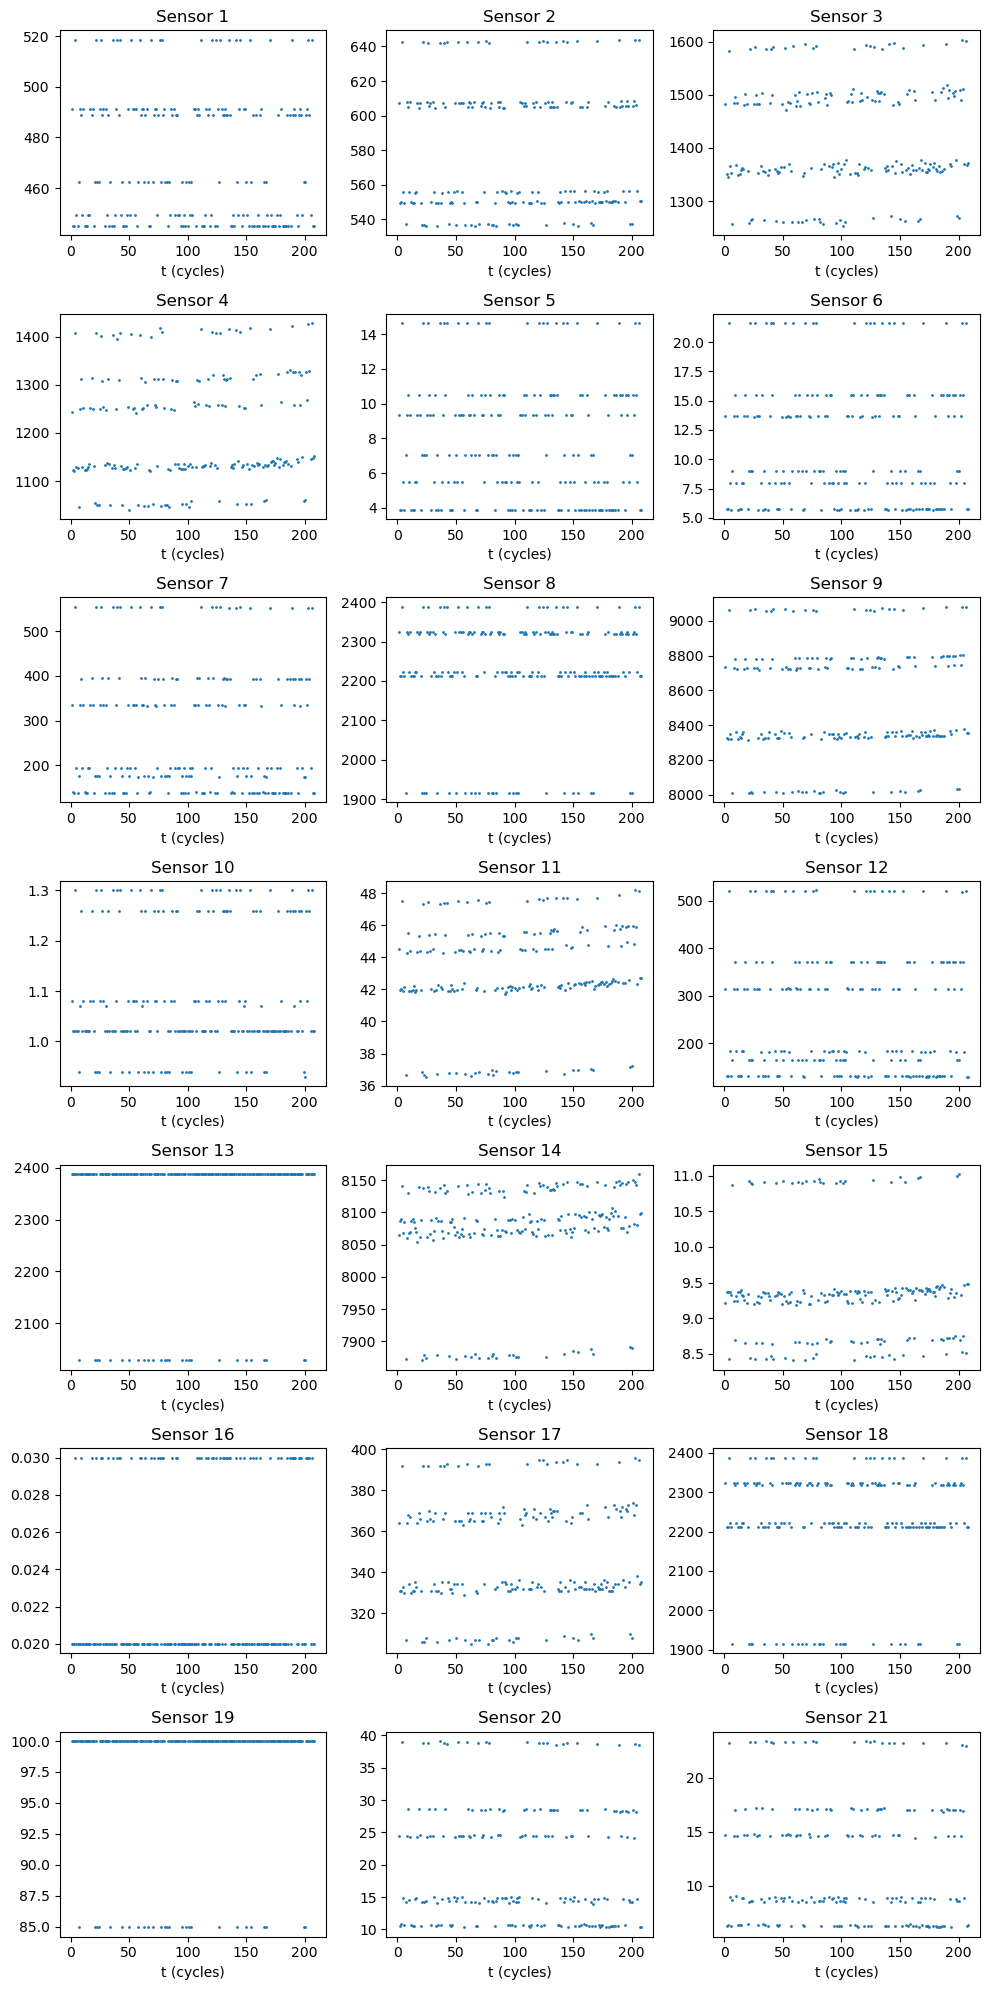

In [195]:
engine_id = 142
sensor_ids = range(1, 22)
plot_all_sensors(raw_train_df, engine_id, sensor_ids)

In [196]:
# Something about np.where - It returns an array of the same shape as the condition
vals = raw_train_df.values
data_list = []  # List of arrays
for i in np.unique(raw_train_df['unit number'].values):
  ind = np.where(raw_train_df['unit number'].values == i)
  data_list.append(vals[ind])
print(len(data_list))

260


In [197]:
n_samples = 5
column_names = list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

Train-Validation Set Split

*   Due to the varying survival durations of the ensemble members or machines, the validation ensembles were selected randomly from the training population.

In [198]:
# Args
  # Ensemble data: Dataframe of all run-to-failure data from a fleet of engines
# Returns:
  # Train and validation sets
  # Unit IDs of the machines in the train and val sets
train_df, val_df, test_df, ytest_df, train_id, val_id, test_id = train_val_test_split(df=raw_train_df, val_percent=0.2, test_percent=0.1, seed=42)
print(f'shape test set: {test_df.shape}, shape validation set: {val_df.shape}, shape train set; {train_df.shape}')
print(f'engines used in the train set: {train_id}')
print(f'engines used in the validation set: {val_id}')
print(f'engines used in the test set: {test_id}')

# Check
val_df.shape[0] + train_df.shape[0] + test_df.shape[0] == raw_train_df.shape[0]
test_df.head(5)

<string>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


shape test set: (97628, 28), shape validation set: (10553, 28), shape train set; (37814, 28)
engines used in the train set: [  1   3   4   5   6   7   9  10  11  12  13  14  15  17  22  24  25  26
  27  30  31  32  33  35  36  37  38  39  40  41  45  46  47  48  49  50
  52  53  54  56  57  58  59  61  62  63  65  66  67  68  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  87  88  89  91  92  96
  97  98  99 100 101 102 104 105 110 111 112 113 117 118 120 121 123 124
 125 126 127 128 129 132 133 134 137 138 140 141 143 144 145 147 148 149
 150 153 154 155 156 158 159 161 166 167 168 170 171 172 173 174 178 179
 182 185 187 188 189 192 193 194 196 198 200 202 203 205 206 207 208 209
 210 212 213 214 217 218 219 223 224 226 227 228 230 231 232 233 235 237
 238 239 240 241 242 245 246 248 249 250 251 252 253 254 255 256 257 258
 259 260]
engines used in the validation set: [135 114  51 201  19  86 220 106  16  44  18 234 197 229 190 103 184 163
 130  69  29  94 116  43 20

,unit number,cycle,op_conditions_1,op_conditions_2,op_conditions_3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,Maxcycle,RUL
0,1,1,10.0028,0.2500,100.0,489.05,604.62,1495.69,1308.38,10.52,...,8140.25,8.6356,0.03,369,2319,100.0,28.50,17.1454,195,194
1,1,2,0.0001,0.0000,100.0,518.67,642.32,1591.03,1403.09,14.62,...,8143.12,8.4156,0.03,392,2388,100.0,38.75,23.2890,195,193
2,1,3,42.0053,0.8415,100.0,445.00,549.01,1350.27,1127.26,3.91,...,8089.51,9.3760,0.02,331,2212,100.0,10.37,6.4091,195,192
3,1,4,0.0022,0.0000,100.0,518.67,642.55,1591.52,1405.36,14.62,...,8148.98,8.3984,0.03,393,2388,100.0,39.06,23.1869,195,191
4,1,5,42.0069,0.8416,100.0,445.00,549.33,1352.13,1123.64,3.91,...,8091.62,9.3644,0.02,331,2212,100.0,10.52,6.3243,195,190


Features and targets

In [199]:
ytrain_df = train_df.pop('RUL')
yval_df = val_df.pop('RUL')
_ = test_df.pop('RUL')
print(train_df.shape, ytrain_df.shape, val_df.shape, yval_df.shape)

(37814, 27) (37814,) (10553, 27) (10553,)


# Working regimen normalization (Set 2 and 4)

Create clusters

*   Run k-means model file
*   Load trained k-means model



In [200]:
loaded_model = joblib.load('kmeans_model')

Create clusters for the train, val and test datasets

In [201]:
op_condts_labels = ['op_conditions_1'	, 'op_conditions_2', 'op_conditions_3']
train_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=train_df, op_condts_labels=op_condts_labels)
val_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=val_df, op_condts_labels=op_condts_labels)
test_cluster_labels = kMeansClustering(kmeans_model = loaded_model, data=test_df, op_condts_labels=op_condts_labels)
print(train_cluster_labels.shape, val_cluster_labels.shape, test_cluster_labels.shape)
print(np.unique(train_cluster_labels), np.unique(val_cluster_labels), np.unique(test_cluster_labels))

(37814,) (10553,) (97628,)
[0 1 2 3 4 5] [0 1 2 3 4 5] [0 1 2 3 4 5]


X data prep

In [202]:
train_df.drop(columns=['Maxcycle'], inplace=True)
val_df.drop(columns=['Maxcycle'], inplace=True)
test_df.drop(columns=['Maxcycle'], inplace=True)

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/1894325112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['Maxcycle'], inplace=True)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/1894325112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns=['Maxcycle'], inplace=True)


In [203]:
x_train = train_df.to_numpy()
x_val = val_df.to_numpy()
x_test = test_df.to_numpy().astype(np.float32)
print(x_train.shape, x_val.shape, x_test.shape)

(37814, 26) (10553, 26) (97628, 26)


Y data prep

In [204]:
y_train = ytrain_df.to_numpy()
y_val = yval_df.to_numpy()
y_test = np.squeeze(ytest_df).to_numpy()
print(y_train.shape, y_val.shape, y_test.shape)

(37814,) (10553,) (780,)


Normalize train dataset by cluster and save normalization parameters

*   Normalize sensors values by clusters
*   Remove NANs

*   Concatenate normalized sensor values with first 5 columns (unit_id, time & operating condts).






In [205]:
def WorkRegimenNorm(data, full_data, parameters_mean_list, parameters_std_list, cluster_labels, no_clusters):
  norm_data = normalize_regime(temp_data = data, cluster_labels = cluster_labels,
                                                  parameters_mean_list=parameters_mean_list,
                                                  parameters_std_list=parameters_std_list)

  # Some checks
  print('Normalized data shape before concat:', norm_data.shape)
  print('No of NaNs before fill:', np.isnan(norm_data).sum())   # Count NAns due to division error

  # Fill NANs with 0
  norm_data[np.isnan(norm_data)] = 0
  print('No of NaNs after fill:', np.isnan(norm_data).sum())

  # Conc first 5 cols
  conc_part = full_data[:full_data.shape[0],:5]
  # Add missing part
  norm_data = np.concatenate((conc_part,norm_data), axis=1)
  print('Normalized data shape after concat:', norm_data.shape)

  return norm_data

x_train data normalization

In [206]:
no_clusters

6

In [207]:
# Create temp unwrap data - 21 columns (only sensors)
cut_train = x_train[:,-21:]
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=6, data=cut_train,
                                                            cluster_labels = train_cluster_labels)
print('parameter list shape:', parameters_mean_list[1].shape)

norm_x_train = WorkRegimenNorm(data=cut_train, full_data = x_train,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=train_cluster_labels, no_clusters=6)

6 6
parameter list shape: (21,)
Normalized data shape before concat: (37814, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (37814, 26)


x_val normalization

In [208]:
cut_val = x_val[:,-21:]
norm_x_val = WorkRegimenNorm(data=cut_val, full_data = x_val,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=val_cluster_labels, no_clusters=6)

Normalized data shape before concat: (10553, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (10553, 26)


x_test normalization

In [209]:
cut_test = x_test[:,-21:]
norm_x_test = WorkRegimenNorm(data=cut_test, full_data = x_test,
                               parameters_mean_list=parameters_mean_list, parameters_std_list=parameters_mean_list,
                               cluster_labels=test_cluster_labels, no_clusters=6)

Normalized data shape before concat: (97628, 21)
No of NaNs before fill: 0
No of NaNs after fill: 0
Normalized data shape after concat: (97628, 26)


Plots after normalization

In [210]:
vals = data_list = []  # List of arrays
for i in np.unique(norm_x_train[:,0]):
  ind = np.where(norm_x_train[:,0] == i)
  data_list.append(norm_x_train[ind])
print(len(data_list))


182


In [211]:
# n_samples = 10
column_names= list(raw_train_df.columns)
sensor_header = list(column_names[5:-2])

In [212]:
raw_train_df.columns

Index(['unit number', 'cycle', 'op_conditions_1', 'op_conditions_2',
       'op_conditions_3', 'sensor measurement 1', 'sensor measurement 2',
       'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5',
       'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8',
       'sensor measurement 9', 'sensor measurement 10',
       'sensor measurement 11', 'sensor measurement 12',
       'sensor measurement 13', 'sensor measurement 14',
       'sensor measurement 15', 'sensor measurement 16',
       'sensor measurement 17', 'sensor measurement 18',
       'sensor measurement 19', 'sensor measurement 20',
       'sensor measurement 21', 'Maxcycle', 'RUL'],
      dtype='object')

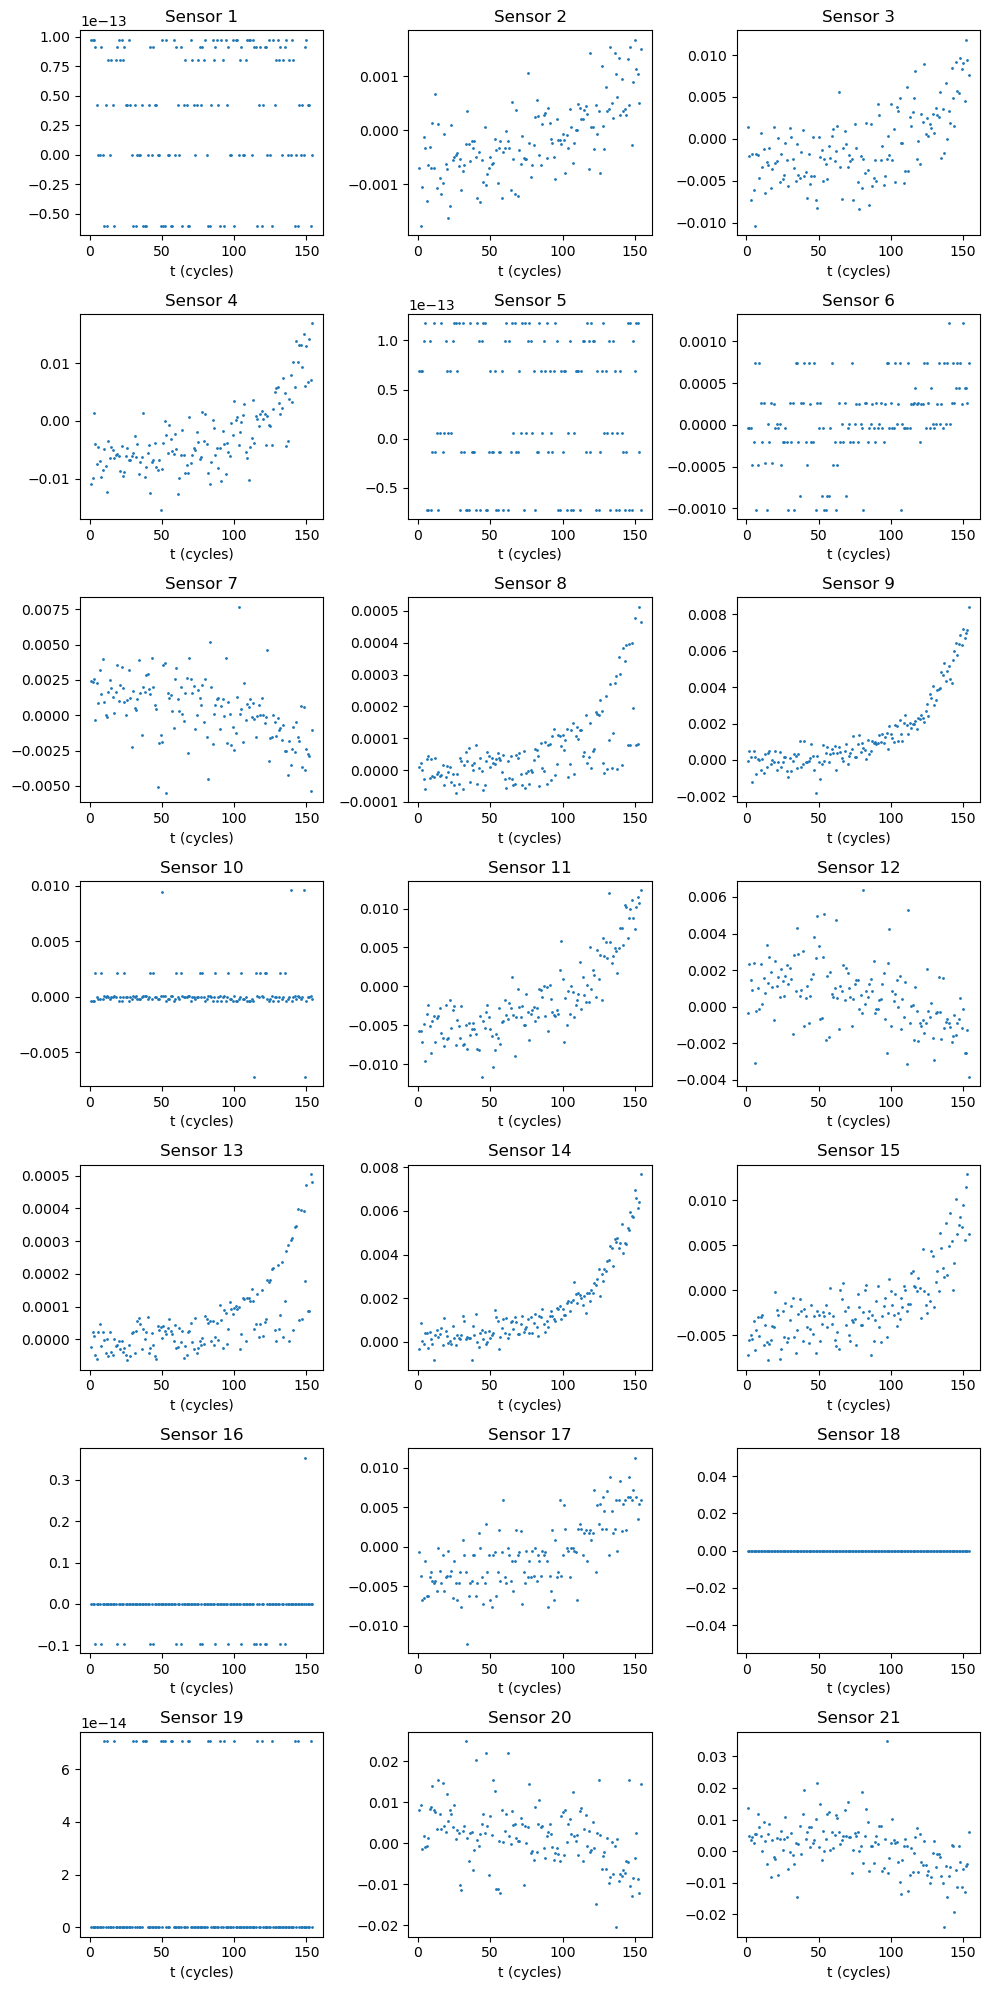

In [213]:
# Let's plot again  (Call split and Plot functions)
sensor_ids = range(1, 22)
#sensor_ids= [2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17,20, 21]
df_norm = pd.DataFrame(norm_x_train, columns=column_names[:-2])
df_norm

plot_all_sensors(df_norm, 5.0, sensor_ids)


Feature Extraction

In [214]:
def featureExtraction(data, desired_sensors):
  cols = desired_sensors+4
  desired_cols = np.append(np.array([0]), cols)
  data = data[:,[desired_cols]]
  return data

In [215]:
desired_sensors = np.array([2,3,4,7,8,9,11,12,13,14,15,17,20,21])
Enorm_x_train = np.squeeze(featureExtraction(norm_x_train, desired_sensors))
Enorm_x_val = np.squeeze(featureExtraction(norm_x_val, desired_sensors))
Enorm_x_test = np.squeeze(featureExtraction(norm_x_test, desired_sensors))
print(Enorm_x_train.shape, Enorm_x_val.shape, Enorm_x_test.shape)

(37814, 15) (10553, 15) (97628, 15)


# Expanding \ Sliding Window (train, Val and test)

X-train, val, test prep

In [216]:
if max_len == T:
  x_train_list = slidingWindow(Enorm_x_train, T)
  x_val_list = slidingWindow(Enorm_x_val, T)
  x_test_list = testSlidingWindow(Enorm_x_test,T)
else:
  x_train_list = expandWindow(Enorm_x_train, min_len=5)
  x_val_list = expandWindow(Enorm_x_val, min_len=5)
  x_test_list = testExpandWindow(Enorm_x_test)
print(len(x_train_list), len(x_val_list), len(x_test_list))

37086 10345 780


 Y-train and val prep

In [217]:
y_train_ind = np.array([Enorm_x_train[:,0], y_train])
y_val_ind =  np.array([Enorm_x_val[:,0], y_val])
y_train_ind = np.transpose(y_train_ind)
y_val_ind = np.transpose(y_val_ind)
print(y_train_ind.shape, y_val_ind.shape)

(37814, 2) (10553, 2)


In [218]:
if max_len == T:
  min_len = T

y_train_list = yPrep(y_train_ind, min_len)
y_val_list = yPrep(y_val_ind, min_len)
print(len(y_train_list), len(y_val_list))

182 52


In [219]:
print(checkY(y_train_list), checkY(y_val_list))

37086 10345


In [220]:
y_trainf = np.concatenate(y_train_list)
y_valf = np.concatenate(y_val_list)
print(y_trainf.shape, y_valf.shape)

(37086,) (10345,)


You might want to save these prepared datasets and reload later

In [221]:
# np.save('FD04_x_train', x_train_list, allow_pickle=True)
# np.save('FD04_x_val', x_val_list, allow_pickle=True)
# np.save('FD04_y_train', y_trainf)
# np.save('FD04_y_val', y_valf)

Use Piecewise RUL values

In [222]:
y_trainf = np.where(y_trainf>125, 125,y_trainf)
y_valf = np.where(y_valf>125, 125,y_valf)
y_testf = np.where(y_test>125, 125,y_test)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(37086,) (10345,) (780,)


Min-max normalization of y

In [223]:
y_trainf = y_trainf.reshape(-1,1)
y_valf = y_valf.reshape(-1,1)
y_testf = y_testf.reshape(-1,1)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(37086, 1) (10345, 1) (780, 1)


In [224]:
y_scaler = MinMaxScaler()
y_scaler.fit(y_trainf)
y_trainf = y_scaler.transform(y_trainf)
y_valf = y_scaler.transform(y_valf)
y_testf = y_scaler.transform(y_testf)
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(37086, 1) (10345, 1) (780, 1)


In [225]:
y_trainf = y_trainf.squeeze()
y_valf = y_valf.squeeze()
y_testf = y_testf.squeeze()
print(y_trainf.shape, y_valf.shape, y_testf.shape)

(37086,) (10345,) (780,)


Prepare dataset for use in pytorch

In [226]:
def collate_superv(data, max_len=max_len):
    """Build mini-batch tensors from a list of (X, y) tuples.
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (1);
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        y: (batch_size,1)
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 ignore (padding)
    """

    batch_size = len(data)
    features, targets = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)

    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep
    # X = x.clone().detach().requires_grad_(True)
    X = X.clone().detach().requires_grad_(True).type('torch.FloatTensor')
    targets = torch.tensor(targets, dtype=torch.float).reshape(-1,1)
    return X, targets, padding_masks

In [227]:
train_dataset = supDataset(data_list=x_train_list, targets=y_trainf)
train_dataloader = DataLoader(dataset=train_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

Some checks

In [228]:
for ret in train_dataloader:

  # X, targets, padding_masks = batch
  break
print(ret[0].shape, ret[1].shape, ret[2].shape)

torch.Size([128, 378, 14]) torch.Size([128, 1]) torch.Size([128, 378])


In [229]:
torch.sum(ret[2], axis=1)

tensor([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132])

In [230]:
val_dataset = supDataset(data_list=x_val_list, targets=y_valf)
val_dataloader = DataLoader(dataset=val_dataset,
                    collate_fn=collate_superv,
                    batch_size=128,
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

In [231]:
test_dataset = supDataset(data_list=x_test_list, targets=y_testf)
test_dataloader = DataLoader(dataset=test_dataset,
                    collate_fn=collate_superv,
                    batch_size=y_testf.shape[0],
                    shuffle=False,
                    # num_workers=2,
                    pin_memory=True)

# Training and Validation

Create device Object

In [232]:
# Check if MPS is available and set the device to MPS, else fall back to CUDA or CPU
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print()

Using device: mps



Train Function

In [233]:
from datetime import datetime
def train_eval(model, criterion, optimizer, train_dataloader, val_dataloader, patience, epochs, exp_no, transform):
  # Collect the train and test loss per epoch
  train_losses = []
  test_losses = []

  # early_stop_thresh = patience
  best_loss = float('inf')
  best_epoch = -1
  patience=patience

  # Loop over no of epochs
  for epoch in range(epochs):
    t0 = datetime.now()
    # Put model in training mode
    model.train()

    # accumulate loss per batch in one epoch
    train_epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    for batch in train_dataloader:

      X, targets, padding_masks = batch[0], batch[1], batch[2]

      # move data to GPU/ any available device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      # regression: (batch_size, num_labels); classification: (batch_size, num_classes) of logits
      predictions = model(X, padding_masks, transform)
      loss = criterion(predictions, targets)  # (batch_size,) loss for each sample in the batch

      # Backward and optimize
      loss.backward()   # Compute Gradients (Back prop)
      optimizer.step()  # Update weights(GD/Adam)

      # Loss of this batch in this epoch
      train_epoch_loss += float(loss.item())*(X.shape[0])
      total_samples += X.shape[0]

    # Get average train loss
    train_epoch_loss = train_epoch_loss / total_samples

    # Make predictions with model at the end of each epoch
    test_epoch_loss = 0
    n_test = 0

    for batch in val_dataloader:
      X, targets, padding_masks = batch[0], batch[1], batch[2]
      # Move test data to device
      X = X.to(device)
      targets = targets.to(device)
      padding_masks = padding_masks.to(device)

      with torch.inference_mode():
        model.eval()
        predictions = model(X, padding_masks, transform)

      loss = criterion(predictions, targets)

      test_epoch_loss += float(loss.item()) *(X.shape[0])
      n_test += X.shape[0]

    test_epoch_loss = test_epoch_loss / n_test

    # Save losses
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)

    dt = datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, \
      Test Loss: {test_epoch_loss:.4f}, Duration: {dt}')

    # MODEL TRACKING/CHECKPOINTS FUNCTIONS
    if test_epoch_loss < best_loss:
      best_loss = test_epoch_loss
      best_epoch = epoch
      torch.save(model, f'best_model{dataset_id}.pt')
      print(f'Best model saved at epoch {epoch+1}')
    if (epoch - best_epoch) > patience:
      print("Early stopped training at epoch %d" % (epoch+1))
      break  # terminate the training loop
    best_model = torch.load(f'best_model{dataset_id}.pt')
  return best_model, best_epoch, train_losses, test_losses

Score function

In [234]:
def score(errors):
  a1=10
  a2=13
  s1=0
  s2=0
  for err in errors:
    if err < 0:
      s1 += (np.exp(-1*(err/a1))) - 1
    if ((err > 0) or (err == 0)):
      s2 += (np.exp(err/a2)) - 1
  return [s1 , s2]

Put It All Together.

In [235]:
d_model = 14
transform = 'linear'

In [236]:
# Instantiate model
# Dropout 0.4 is the sweet spot
model = TSTransformerEncoderClassiregressor(feat_dim=14, max_len=max_len, d_model=d_model, n_heads=2, num_layers=2, dim_feedforward=10, num_classes=1,
                 dropout=0.4, pos_encoding='fixed', activation='gelu', norm='LayerNorm', freeze=False, transform=transform)
# Move model to the gpu if available ()
# Note: If you need to move a model to GPU via .cuda() ,
# please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.
model.to(device)

# Instantiate loss and optimizer of choice
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [237]:
# # Call the train function
# best_model, best_epoch, train_losses, val_losses = train_eval(model, criterion, optimizer, train_dataloader,
#                                                               val_dataloader, patience=20, epochs=150, exp_no=1, transform=transform)

# # Plot Loss
# plot_loss_accuracy("Transformer", train_losses=train_losses, test_losses=val_losses)

# Validation

In [238]:
best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)

In [239]:
with torch.inference_mode():
  best_model.eval()

  for batch in val_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [240]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES,RMSE, MAE)

[array([210.6581], dtype=float32), 0] 10.936575 10.161074


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Testing

In [241]:
best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)

In [242]:
with torch.inference_mode():
  best_model.eval()

  for batch in test_dataloader:

    X, targets, padding_masks = batch[0], batch[1], batch[2]

    # move data to GPU/ any available device
    X = X.to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions with best model
    y_pred = best_model(X, padding_masks, transform)

In [243]:
y_predb = torch.Tensor.cpu(y_pred).detach().numpy()
y_test = torch.Tensor.cpu(targets).detach().numpy()

# Inverse transform
y_predb = y_scaler.inverse_transform(y_predb)
y_test = y_scaler.inverse_transform(y_test)

# Get score and RMSE
RMSE = mean_squared_error(y_predb, y_test, squared=False)
MAE = mean_absolute_error(y_predb, y_test)
error = y_predb -  y_test
SCORES = score(error)
print(SCORES, RMSE, MAE)


[array([1232.209], dtype=float32), array([563.25134], dtype=float32)] 12.5405855 10.157417


/opt/anaconda3/envs/Maintenance/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 0, 'True RUL')

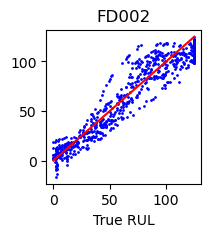

In [244]:
ind = np.argsort(-y_test.squeeze(1))
plt.figure(figsize=(2,2));

plt.title(f'FD00{dataset_id}')
plt.scatter(y_test, y_predb, color='blue', s=1)
plt.plot([0,125],[0,125], color='red')
plt.xlabel('True RUL')
#plt.ylabel('Predicted RUL')

# Post Model Interpretability: LIME

In [264]:
print(f'Engines in this test set: {test_id}')

Engines in this test set: [222  60 142  64 165 131 119 181 107 186 244 152  20 236 199 162 109   2
 122 164 146 136 180   8  34  28]


In [285]:
from lime import lime_tabular
import seaborn as sns


#Choose a sample to explain
engine_index = 2 # Choose an engine from the test set
sample = 8 # Between 1 and 30

print(f'You have chosen engine {test_id[engine_index]}')
print(f'This engine has the followin RUL values: {y_test[engine_index*30:(engine_index+1)*30].flatten()}')

index = engine_index*30 + sample -1 # Index of the test set to be analyzed
print(f'RUL value of this sample: {y_test[index]}')

You have chosen engine 142
This engine has the followin RUL values: [125. 125.  88.  96. 101. 123. 125.  19. 125.  50. 125. 125. 125. 103.
  99.  29.   1. 108.   7.  51. 102.  44.  87. 125. 118.   9.  71.  22.
 119.  13.]
RUL value of this sample: [19.]


In [282]:
# Define a wrapper for the forward method
class ModelWrapper(nn.Module):
    def __init__(self, model, transform, max_len=max_len):
        super(ModelWrapper, self).__init__()  # Initialize the parent class
        self.model = model
        self.transform = transform
        self.max_len = max_len

    def forward(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).detach().to(device)
        X_tensor = torch.reshape(torch.tensor(X_tensor), (-1, self.max_len, 14))
        lengths = []
        for x in X_tensor.numpy():
            i = 0
            for timepoint in x:
                if np.all(timepoint == 0):
                    break
                i += 1
            lengths.append(i)

        self.padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16), max_len=self.max_len)
        return self.model(X_tensor, self.padding_masks, self.transform)

In [283]:
if dataset_id == 2:
    max_len = 378
elif dataset_id == 4:
    pass

with torch.inference_mode():

    # Ensure device is set (assuming you're using GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    best_model = torch.load(f'trained_models/{dataset_id}_model_final.pt', map_location=device)
    best_model.to(device)
    best_model.eval()

    # Instantiate the wrapped model
    wrapper = ModelWrapper(best_model, 'linear', max_len=max_len)
    
    # Get the test set
    for batch in test_dataloader:
        X, targets, padding_masks = batch[0], batch[1], batch[2]
        #print(X.shape, targets.shape, padding_masks.shape)
        break  # Just take the first batch for simplicity
        
    # Move data to GPU/ any available device
    X =  torch.tensor(X, dtype=torch.float32).to(device)
    targets = targets.to(device)
    padding_masks = padding_masks.to(device)

    # Make predictions to verify the model works
    true = y_scaler.inverse_transform(np.array(targets.detach().numpy()[index]).reshape(-1, 1))
    prediction = y_scaler.inverse_transform(wrapper(X[index]))
    print(f'The model predits; {prediction}')
    print(f'The true RUL is: {true}')
    
    # Convert padding_mask to match the batch dimension
    X_ref = X.detach().numpy()
    masks = padding_masks[index]
    batch_size = X.shape[0]
    padding_mask_expanded = np.expand_dims(masks, axis=0)
    padding_mask_expanded = np.repeat(padding_mask_expanded, batch_size, axis=0)

    # Apply the padding mask to X
    X_masked = X_ref.copy()  # Create a copy to avoid modifying the original data
    X_masked[~padding_mask_expanded] = 0

    # Convert to tensor and reshape
    X = torch.tensor(X_masked, dtype=torch.float32).to(device)
    X = torch.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))
    X = X.detach().numpy()

    # Create feature names
    feature_names = [f"time_{i}_sensor_{j}" for i in range(max_len) for j in range(14)]

    # Create the explainer
    explainer = lime_tabular.LimeTabularExplainer(X,feature_names=feature_names, mode='regression', verbose=True)

    # Explain the instance
    exp = explainer.explain_instance(X[index], wrapper, num_features=5068, num_samples=30000)

/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/1803209116.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X =  torch.tensor(X, dtype=torch.float32).to(device)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/845727892.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).detach().to(device)
/var/folders/gm/pvnntq692jd5ng0rtk5l0z9m0000gn/T/ipykernel_30358/845727892.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.reshape(torch.tensor(

The model predits; [[6.74090348]]
The true RUL is: [[19.]]


KeyboardInterrupt: 

Plot a heatmap of the LIME values

[('time_0_sensor_6 > 0.00', 0.01083745916961259), ('time_172_sensor_6 > 0.00', -0.010532250181205346), ('time_177_sensor_2 > 0.00', -0.010024771861850417), ('time_177_sensor_6 > 0.00', -0.009540584710667845), ('time_177_sensor_1 > 0.00', -0.00913020338248389), ('time_5_sensor_2 > -0.00', 0.00883115994570777), ('time_176_sensor_2 > 0.00', -0.008488351865472511), ('time_182_sensor_2 > 0.00', -0.008411521087540036), ('time_128_sensor_1 > 0.00', -0.00820489858859935), ('time_8_sensor_2 > -0.00', 0.008053354323036466), ('time_187_sensor_6 > 0.00', -0.008008518295895288), ('time_6_sensor_1 <= -0.00', -0.007997519687051816), ('time_20_sensor_6 > -0.00', 0.007920223955704743), ('time_188_sensor_6 > 0.00', -0.007907237895796154), ('time_31_sensor_2 > -0.00', 0.007895681603202698), ('time_177_sensor_10 <= 0.00', 0.0078278135434289), ('time_171_sensor_2 > 0.00', -0.00782740689619669), ('time_178_sensor_6 > 0.00', -0.007769788691535459), ('time_154_sensor_6 > 0.00', -0.007676760649996241), ('time_

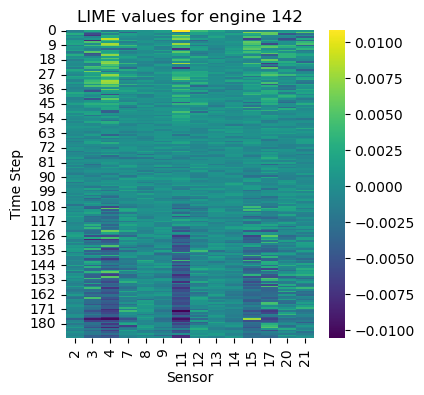

In [286]:
sensor_names = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
max_cycle = x_test_list[index].shape[0]


lime_values = exp.as_list()
print(lime_values)
#exp.show_in_notebook(show_table=True)

# Extract and correctly parse the LIME values
lime_values = np.zeros(max_cycle * 14)
for feature, importance in exp.as_list():
    # Extract time step and sensor indices from the feature name
    parts = feature.split('_')
    time_step = int(parts[1])
    sensor = int(parts[3].split(' ')[0])
    index2 = time_step * 14 + sensor
    if time_step < max_cycle:
        lime_values[index2] = importance

# Reshape the LIME values to (362, 14)
lime_values_reshaped = lime_values.reshape(max_cycle, 14)

# Plot a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(lime_values_reshaped, cmap="viridis", annot=False, xticklabels=sensor_names)
plt.title(f"LIME values for engine {test_id[engine_index]}")
plt.xlabel("Sensor")
plt.ylabel("Time Step")
plt.show()

Plot the time dependance of the lime values.

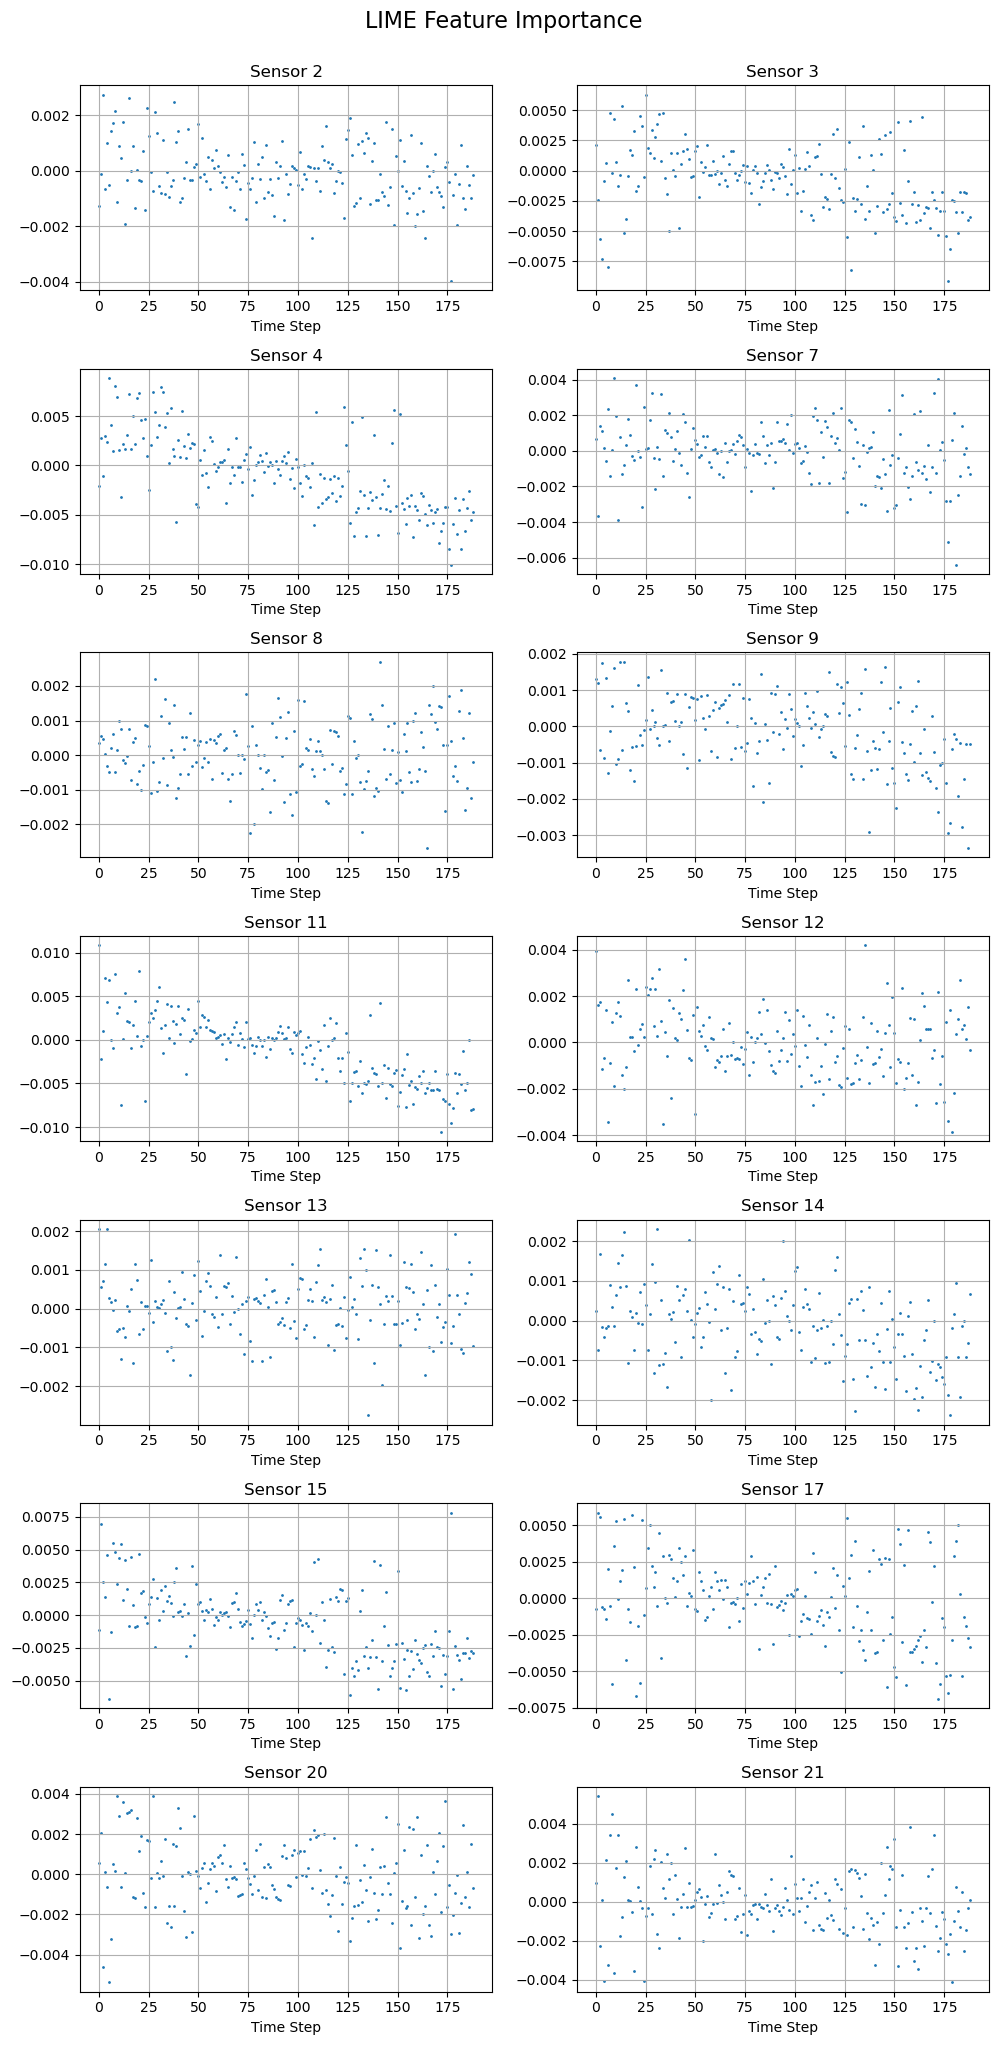

Sensor 2: Sum of LIME values = -0.02
Sensor 3: Sum of LIME values = -0.15
Sensor 4: Sum of LIME values = -0.14
Sensor 7: Sum of LIME values = -0.01
Sensor 8: Sum of LIME values = 0.01
Sensor 9: Sum of LIME values = -0.03
Sensor 11: Sum of LIME values = -0.22
Sensor 12: Sum of LIME values = -0.00
Sensor 13: Sum of LIME values = 0.01
Sensor 14: Sum of LIME values = -0.03
Sensor 15: Sum of LIME values = -0.11
Sensor 17: Sum of LIME values = -0.04
Sensor 20: Sum of LIME values = -0.02
Sensor 21: Sum of LIME values = -0.02


In [250]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lime_importance(lime_values_reshaped, sensor_names, title='LIME Feature Importance'):
    # Number of subfigures, define the grid layout
    n_subfigures = len(sensor_names)
    rows = 7
    cols = math.ceil(n_subfigures / 7)

    time_steps = np.arange(lime_values_reshaped.shape[0])
    
    # Create the figure and axes objects
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 20))
    
    # Initialize an empty list to hold the sum of LIME values
    lime_sums = []

    # Loop over all possible subplots within the grid
    for i in range(n_subfigures):
        ax = axes[i // cols, i % cols]  # Locate the right subplot
        if i < n_subfigures:
            sensor_data = lime_values_reshaped[:, i]
            
            ax.scatter(time_steps, sensor_data, s=1)
            ax.set_xlabel('Time Step')
            ax.set_title(f"Sensor {sensor_names[i]}")
            ax.grid(True)

            # Calculate and store the sum of LIME values for the current sensor
            lime_sum = np.sum(sensor_data)
            lime_sums.append((sensor_names[i], lime_sum))
        else:
            ax.axis('off')  # Turn off axis for unused plots
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()
    
    # Print the sum of LIME values for each sensor
    for sensor_name, lime_sum in lime_sums:
        print(f"Sensor {sensor_name}: Sum of LIME values = {lime_sum:.2f}")

# Assuming lime_values_reshaped is already defined and has shape (362, 14) or (max_cycle, 14)
sensor_names = [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]  # List of sensor names to plot

plot_lime_importance(lime_values_reshaped, sensor_names)




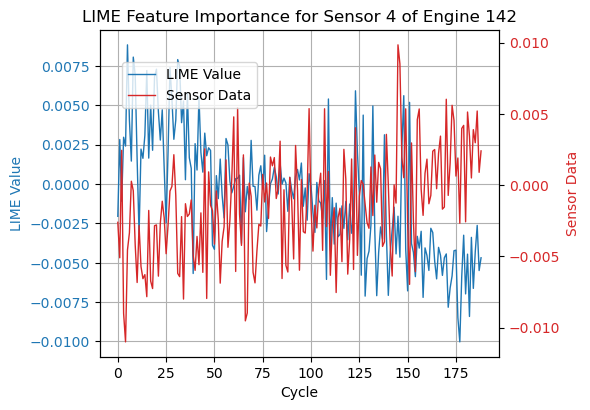

In [261]:
import matplotlib.pyplot as plt

# Assuming lime_values_reshaped is already defined and has shape (362, 14) or (max_cycle, 14)
# dict with sensor names and index for lime
sensor_names = {2: 0, 3: 1, 4: 2, 7: 3, 8: 4, 9: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 17: 11, 20: 12, 21: 13}
sensor = 4

engine = df_norm[df_norm['unit number'] == 4.0]
sensor_data = engine[f'sensor measurement {sensor}'].values

# Extract the LIME values for the selected sensor
sensor_values = lime_values_reshaped[:, sensor_names[sensor]]
cycles = range(len(sensor_values))

#index min LIME value
min_lime = np.argmin(sensor_values)


# Plot the LIME values for the selected sensor
fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:blue'
ax1.set_xlabel('Cycle')
ax1.set_ylabel('LIME Value', color=color)
ax1.plot(cycles, sensor_values, color=color, label='LIME Value', linewidth=1)
#ax1.scatter(min_lime, sensor_values[min_lime], color='red', label='Min LIME Value', s=10)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Sensor Data', color=color)
ax2.plot(cycles, sensor_data[0:len(cycles)], color=color, label='Sensor Data', linewidth=1)
#ax2.scatter(min_lime, sensor_data[min_lime], color='red', label='Min LIME Value', s=10)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust layout to prevent overlap

plt.title(f"LIME Feature Importance for Sensor {sensor} of Engine {test_id[engine_index]}")
fig.legend(loc="upper left", bbox_to_anchor=(0.2, 0.9))

plt.show()
